# Figure with clusters and model fit for the integrated approach

This figure will contain the fitting results of the dynamic VAE model.
The data for creating the figure is generate in the notebook `IntegratedApproach.ipynb`

To make the figure, we take the following steps:

1. import data
2. give names to clusters
3. show marker expression in UMAP space
4. show clusters in UMAP space
5. plot the heatmap of marker expression
6. plot timeseries of relative cluster sizes
7. plot fit to cell counts
8. plot parameter estimates and the the Q matrix

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib

import scdynsys.plots as plots
import scdynsys.utilities as utils

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

## Import data required for the figure.

In [2]:

with open("../results/data_IA_fitting.pkl", 'rb') as f:
    data_figure_IA_fit = pickle.load(f)
    
raw_latent_umap = data_figure_IA_fit["raw_latent_umap"]
sel_markers = data_figure_IA_fit["sel_markers"]
raw_data = data_figure_IA_fit["raw_data"]
MFI = data_figure_IA_fit["MFI"]
raw_clus = data_figure_IA_fit["raw_clus"]
umap_sampled_per_clus = data_figure_IA_fit["umap_sampled_per_clus"]
clus_relabel_dict = data_figure_IA_fit["clus_relabel_dict"]
sample_density_umap = data_figure_IA_fit["sample_density_umap"]
T0 = data_figure_IA_fit["T0"]
ts_raw = data_figure_IA_fit["ts_raw"]
yhats_raw = data_figure_IA_fit["yhats_raw"]
raw_count_data_combined = data_figure_IA_fit["raw_count_data_combined"]
clus_freq_array = data_figure_IA_fit["clus_freq_array"]
weights_raw = data_figure_IA_fit["weights_raw"]
unique_batch = data_figure_IA_fit["unique_batch"]
batch_day_dict = data_figure_IA_fit["batch_day_dict"]
ysims_raw = data_figure_IA_fit["ysims_raw"]
count_scaling = data_figure_IA_fit["count_scaling"]

rho_sam = data_figure_IA_fit["rho_sam"]
loc_rho_sam = data_figure_IA_fit["loc_rho_sam"]
eta_sam = data_figure_IA_fit["eta_sam"]
loc_eta_sam = data_figure_IA_fit["loc_eta_sam"]
Qsams = data_figure_IA_fit["Qsams"]


num_clus = len(clus_relabel_dict)
clus_sorted_by_size = sorted(list(range(num_clus)), key=lambda x: clus_relabel_dict[x])

num_markers = len(sel_markers)

## Give names to clusters / populations

these names will be used in the figure

The names will also be used in SI figures, so we save them to a pickle.

In [3]:
# simplified cluster names

cluster_names = [
    "TRM 1",
    "TRM 2",
    "TEM 1",
    "TRM 3",
    "Teff",
    "TCM",
    "TEM 2",
    "TEM 3",
    "TRM 4",
    "TRM 5"
]

# for the timeseries panel, we add celltype descriptions for clarity"

cluster_descriptions = {
    "TRM 1" : "CD69$^\\text{hi}$",
    "TRM 2" : "CD69$^\\text{hi}$ CD103$^{\\text{hi}}$",
    "TEM 1" : "CD27$^\\text{hi}$",
    "TRM 3" : "CD103$^\\text{hi}$",
    "Teff" : "Klrg1$^\\text{hi}$",
    "TCM" : "CD62L$^\\text{hi}$",
    "TEM 2" : "Bcl2$^\\text{hi}$",
    "TEM 3" : "CX3CR1$^\\text{hi}$",
    "TRM 4" : "CX3CR1$^\\text{hi}$",
    "TRM 5" : "Bcl2$^\\text{hi}$",
}

lineage = "CD8"

assert len(cluster_names) == num_clus, "check number of clusters and cluster names!"

# save cluster names for downstream figures

with open("../results/fancy_names_IA_CD8.pkl", 'wb') as f:
    pickle.dump(cluster_names, f)

## Create the matplotlib figure

This requires some creative use of `GridSpec`

In [4]:
hsize = 14
axmul = 3
hnum = 10
vnum = 9

fig = plt.figure(figsize=(hsize, vnum * hsize / hnum * 1.05))

gs = GridSpec(vnum * axmul, hnum * axmul)

labx, laby = -0.1, 1.1

fig.subplots_adjust(wspace=0.1, hspace=0.4)

<Figure size 1400x1323 with 0 Axes>

### Show the distribution of markers in the (umapped) latent space

In [5]:
axs_expr_umap = []

for i, m in enumerate(sel_markers):
    ax = fig.add_subplot(gs[0:axmul, i*axmul:(i+1)*axmul])
    axs_expr_umap.append(ax)
    xs = raw_latent_umap[:,0]
    ys = raw_latent_umap[:,1]
    zs = raw_data[:,i]
    ax.scatter(xs, ys, c=zs, linewidths=0, s=1, rasterized=True)
    ax.set_title(m)
    ax.set_xticks([])
    ax.set_yticks([])
    
axs_expr_umap[0].set_xlabel("UMAP 1")
axs_expr_umap[0].set_ylabel("UMAP 2")

# label

Ax = fig.add_subplot(gs[0:axmul, 0:3*axmul])
Ax.axis('off')
Ax.text(-0.1, 1.1, "A", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.1, 'A')

### Plot location of clusters

In [6]:
ax = fig.add_subplot(gs[axmul+1:4*axmul+1, 0:3*axmul])

clus_colors = np.array([tabcolors[clus_relabel_dict[i]] for i in raw_clus])
N = raw_data.shape[0]
perm = np.random.choice(N, N, replace=False)

ax.scatter(
    raw_latent_umap[perm, 0], 
    raw_latent_umap[perm, 1], 
    c=sample_density_umap[perm], linewidths=0, s=1,
    rasterized=True
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

## compute HPD regions of each cluster and draw contour
patches = []
for i, clus in enumerate(clus_sorted_by_size):
    t_sam = umap_sampled_per_clus[clus]["samples"]
    patch = plots.plot_hpd_contour(
        ax, t_sam, color=tabcolors[i], 
        linewidth=3
    )
    patches.append(patch)
    tloc_sam = umap_sampled_per_clus[clus]["loc"]    
    ax.scatter(tloc_sam[:,0], tloc_sam[:,1], color=tabcolors[i], s=1, rasterized=True)

# label
Ax = fig.add_subplot(gs[axmul+1:2*axmul+1, 0:3*axmul])
Ax.axis('off')
Ax.text(labx, laby, "B", fontsize='xx-large', transform=Ax.transAxes)
    
## plot cluster assignment
bx = fig.add_subplot(gs[axmul+1:4*axmul+1, 4*axmul-1:7*axmul-1])

bx.scatter(
    raw_latent_umap[perm, 0], 
    raw_latent_umap[perm, 1], 
    c=clus_colors[perm], linewidths=0, s=1, 
    rasterized=True
)

bx.set_xticks([])
bx.set_yticks([])

bx.set_xlabel("UMAP 1")

# label
Bx = fig.add_subplot(gs[axmul+1:2*axmul+1, 4*axmul-1:7*axmul-1])
Bx.axis('off')
Bx.text(labx, laby, "C", fontsize='xx-large', transform=Bx.transAxes)


# arrow from ax to bx
ax.annotate(
    "", xy=(0, 0.5), xytext=(1, 0.5), 
    xycoords=bx.transAxes, textcoords=ax.transAxes,
    arrowprops=dict(arrowstyle='->')
)

# create a subplot in between the UMAPs to align test box

cx = fig.add_subplot(gs[1*axmul+1:4*axmul+1, 3*axmul:4*axmul-1])
cx.axis('off')

props = dict(boxstyle='round', facecolor='w')

cx.text(
    0.0, 0.55, "Sample\ncluster\nassignment", 
    va='bottom', ha='center',
    transform=cx.transAxes,
    bbox=props
)

ax_sam_clus = bx

### Plot the Heatmap

In [7]:
ax = fig.add_subplot(gs[axmul+1:4*axmul, 7*axmul+1:9*axmul+1])

# move y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# make sure MFI is properly z-scored
MFI = sts.zscore(MFI, axis=0) ## axis=0 means standardize over the the cell types!

plots.simple_heatmap(ax, MFI[::-1,:], sel_markers, cluster_names[::-1])

for i, tick in enumerate(ax.get_yticklabels()):
    tick.set_rotation(-45)
    tick.set_color(tabcolors[num_clus-i-1])


ax.set_ylabel(f"{lineage} T cell population")
ax.set_xlabel("Marker")

ax_heat = ax

# add axes for drawing an arrow from sampling plot to heatmap plot
Ax_heat = fig.add_subplot(gs[axmul+1:4*axmul+1, 7*axmul+1:])
Ax_heat.axis('off')

# label
Ax = fig.add_subplot(gs[axmul+1:2*axmul+1, 7*axmul+1:])
Ax.axis('off')
Ax.text(labx, laby, "D", fontsize='xx-large', transform=Ax.transAxes)

# add arrow from cluster assignment plot to heatmap

# arrow from ax_sam_clus to ax
ax_sam_clus.annotate(
    "", xy=(0, 0.5), xytext=(1, 0.5), 
    xycoords=Ax_heat.transAxes, textcoords=ax_sam_clus.transAxes,
    arrowprops=dict(arrowstyle='->')
)

# text box for mean fluorescence calculation
props = dict(boxstyle='round', facecolor='w')

ax_sam_clus.text(
    1.0, 0.55, "Calculate\nmean\nfluorescence", 
    va='bottom', ha='center',
    transform=ax_sam_clus.transAxes,
    bbox=props
)

# arrows from expression umaps to heatmap
axs_connect = axs_expr_umap[-3:]

offsets = np.linspace(num_markers-2, num_markers, 3) - 0.5

for offset, ax in zip(offsets, axs_connect):
    ax_heat.annotate(
        "", xy=(offset, num_clus), xytext=(0.7, 0.0),
        xycoords=ax_heat.transData, 
        textcoords=ax.transAxes,
        arrowprops=dict(arrowstyle='->')
    )

# text box to indicate manual annotation
ax_heat.text(
    1.0, 1.07, "Annotate clusters", 
    va='bottom', ha='center',
    transform=ax_heat.transAxes,
    bbox=props
)

Text(1.0, 1.07, 'Annotate clusters')

### Plot cluster frequencies

In [8]:
ax_freq = fig.add_subplot(gs[5*axmul:7*axmul, 0:3*axmul])
plots.remove_axes_keep_labels(ax_freq)
ax_freq.set_ylabel(f"Fraction of {lineage} T cells in lung")    

tticks = [14, 28, 42, 56]

axs = []

ylab_coord = -0.25

popname_pos = {
    **dict.fromkeys([1, 5, 6, 9], (0.97, 0.1)), 
    **dict.fromkeys([0, 2, 3, 4, 7, 8], (0.97, 0.9))
}

for i, clus in enumerate(clus_sorted_by_size):
    color = tabcolors[i]
    u, v = divmod(i, 5)
    ax = fig.add_subplot(gs[(5+u)*axmul:(6+u)*axmul, 2*v*axmul+1:2*(v+1)*axmul])
    axs.append(ax)
    xs = clus_freq_array[:,clus]
    ts = [batch_day_dict[b] for b in unique_batch]
    ax.scatter(ts, xs, color=color, s=10, zorder=3, linewidths=0)
    
    ws = weights_raw[:,:,clus]
    xhat_med = np.median(ws, axis=0)
    xhat_low = np.percentile(ws, axis=0, q=2.5)
    xhat_high = np.percentile(ws, axis=0, q=97.5)

    ax.plot(T0 + ts_raw, xhat_med, color=color, zorder=2)
    ax.fill_between(
        T0 + ts_raw, xhat_low, xhat_high, 
        color=color, alpha=0.3, zorder=1,
        linewidth=0
    )
    clus_name = cluster_names[i]
    clus_descr = f"{clus_name} ({cluster_descriptions[clus_name]})"
    ax.text(*popname_pos[i], clus_descr, 
            transform=ax.transAxes, va='center', ha='right')    

    # adjust font size of yticks
    ax.tick_params(axis='y', labelsize='x-small')
    if u == 0:
        ax.set_xticks([])
    else:
        ax.set_xticks(tticks)
        ax.set_xlabel("DPI")
    
# add arrows from sampling UMAP to freq plots

axs_connect = [axs[0], axs[1], axs[2]]
offsets = [-0.1, 0.0, 0.1]

for offset, ax in zip(offsets, axs_connect):
    ax_sam_clus.annotate(
        "", xy=(0.5, 1.0), xytext=(0.2+offset, 0.0),
        xycoords=ax.transAxes, 
        textcoords=ax_sam_clus.transAxes,
        arrowprops=dict(arrowstyle='->')
    )
    
    
props = dict(boxstyle='round', facecolor='w')

ax_sam_clus.text(
    0.1, -0.1, 
    "Generate timeseries\n of population fractions",
    bbox=props,
    transform=ax_sam_clus.transAxes,
    va='center', ha='center'
)

# label

ax_freq.text(-0.1, 1.05, "E", fontsize='xx-large', transform=ax_freq.transAxes)

Text(-0.1, 1.05, 'E')

### Plot fit to cell counts

In [9]:
ax = fig.add_subplot(gs[7*axmul+2:9*axmul, 0:2*axmul])

ts = np.array([x[0] for x in raw_count_data_combined])
ys = np.array([x[1] for x in raw_count_data_combined])
ax.scatter(T0 + ts, ys * count_scaling, s=10, color='k', zorder=4, linewidths=0)

yhat_med = np.median(yhats_raw, axis=0)
yhat_low = np.percentile(yhats_raw, axis=0, q=2.5)
yhat_high = np.percentile(yhats_raw, axis=0, q=97.5)

# credible envelope
ax.plot(T0 + ts_raw, yhat_med * count_scaling, color='blue', zorder=3)
ax.fill_between(
    T0 + ts_raw, yhat_low * count_scaling, yhat_high * count_scaling, 
    color='blue', zorder=2, linewidth=0, alpha=0.3
)

# posterior predictive envelope
ysim_low = np.percentile(ysims_raw, axis=0, q=2.5)
ysim_high = np.percentile(ysims_raw, axis=0, q=97.5)
ax.fill_between(
    T0 + ts_raw, ysim_low * count_scaling, ysim_high * count_scaling, 
    color='blue', zorder=1, linewidth=0, alpha=0.2
)


ax.set_yscale('log')

ax.set_xlabel("DPI")
ax.set_xticks(tticks)
ax.set_ylabel(f"{lineage} T cells in lung")

# label
ax.text(-0.2, 1.05, "F", fontsize='xx-large', transform=ax.transAxes)

ax_counts = ax

### Plot parameter estimates

In [10]:
def plot_mpd(ax, pos, sam, xlabels):
    ax.violinplot(sam, positions=pos, showextrema=False)
    plots.simple_boxplot(ax, pos, sam.T)
    ax.set_xticks(pos)
    ax.set_xticklabels(xlabels, rotation=45, ha='right')
    
def append_loc_to_sams(sams, locs):
    return np.concatenate([sams.T, np.expand_dims(locs, 1).T]).T

ylab_coord = -0.15

ax = fig.add_subplot(gs[7*axmul+2:9*axmul, 2*axmul+2:4*axmul+2])
# paste loc param to unit params
rho = append_loc_to_sams(rho_sam[:, clus_sorted_by_size], loc_rho_sam)
lam_E = -rho
plot_mpd(ax, range(num_clus+1), lam_E, cluster_names + ["average"])
ax.axvline(num_clus-0.5, color='k', linewidth=0.5)
ax.set_ylabel(r'Early net loss ($\lambda_E$)')
ax.yaxis.set_label_coords(ylab_coord, 0.5)

ax.set_yticks(np.linspace(-0.5, 1.5, 5))
ax.axhline(y=0, color='0.7', linestyle='--')


# label
ax.text(-0.2, 1.05, "G", fontsize='xx-large', transform=ax.transAxes)


## plot long-term loss rates
bx = fig.add_subplot(gs[7*axmul+2:9*axmul, 5*axmul+1:7*axmul+1], sharey=ax)
if eta_sam is not None:
    # paste loc param to unit params
    eta = append_loc_to_sams(eta_sam[:, clus_sorted_by_size], loc_eta_sam)
    lam_L = -eta
    plot_mpd(bx, range(num_clus+1), lam_L, cluster_names + ["average"])
    bx.axvline(num_clus-0.5, color='k', linewidth=0.5)
    bx.set_ylabel(r"Late net loss ($\lambda_L$)")
    bx.yaxis.set_label_coords(ylab_coord, 0.5)

    bx.set_yticks(np.linspace(-0.5, 2.5, 7))
    bx.set_ylim(-0.5, 2.5)
    bx.axhline(y=0, color='0.7', linestyle='--')
else:
    bx.axis("off")


### Plot the Q-matrix

In [11]:
ax = fig.add_subplot(gs[7*axmul+2:9*axmul, 8*axmul:10*axmul-1])

unique_clus = list(range(num_clus))
cx = plots.plot_diff_matrix_vae(
    ax, Qsams, unique_clus, clus_sorted_by_size,
    {i : cluster_names[i] for i in unique_clus},
    num_cticks=4, ctick_formatter="${:0.2f}$"
)

ax.set_xticks(np.array(range(num_clus)) + 0.5)
ax.set_yticks(np.array(range(num_clus)) + 0.5)
ax.set_aspect('equal', anchor='SW')

ax.set_xticklabels(cluster_names, rotation=45, ha='right', fontsize='small')
ax.set_yticklabels(cluster_names, rotation=45, fontsize='small')

ax.set_xlabel("Source")
ax.set_ylabel("Destination")

#cx = fig.colorbar(cs, ax=ax)
cx.set_label("Differentiation rate ($Q_{ij}$)")

# label
ax.text(-0.2, 1.05, "H", fontsize='xx-large', transform=ax.transAxes)

Text(-0.2, 1.05, 'H')

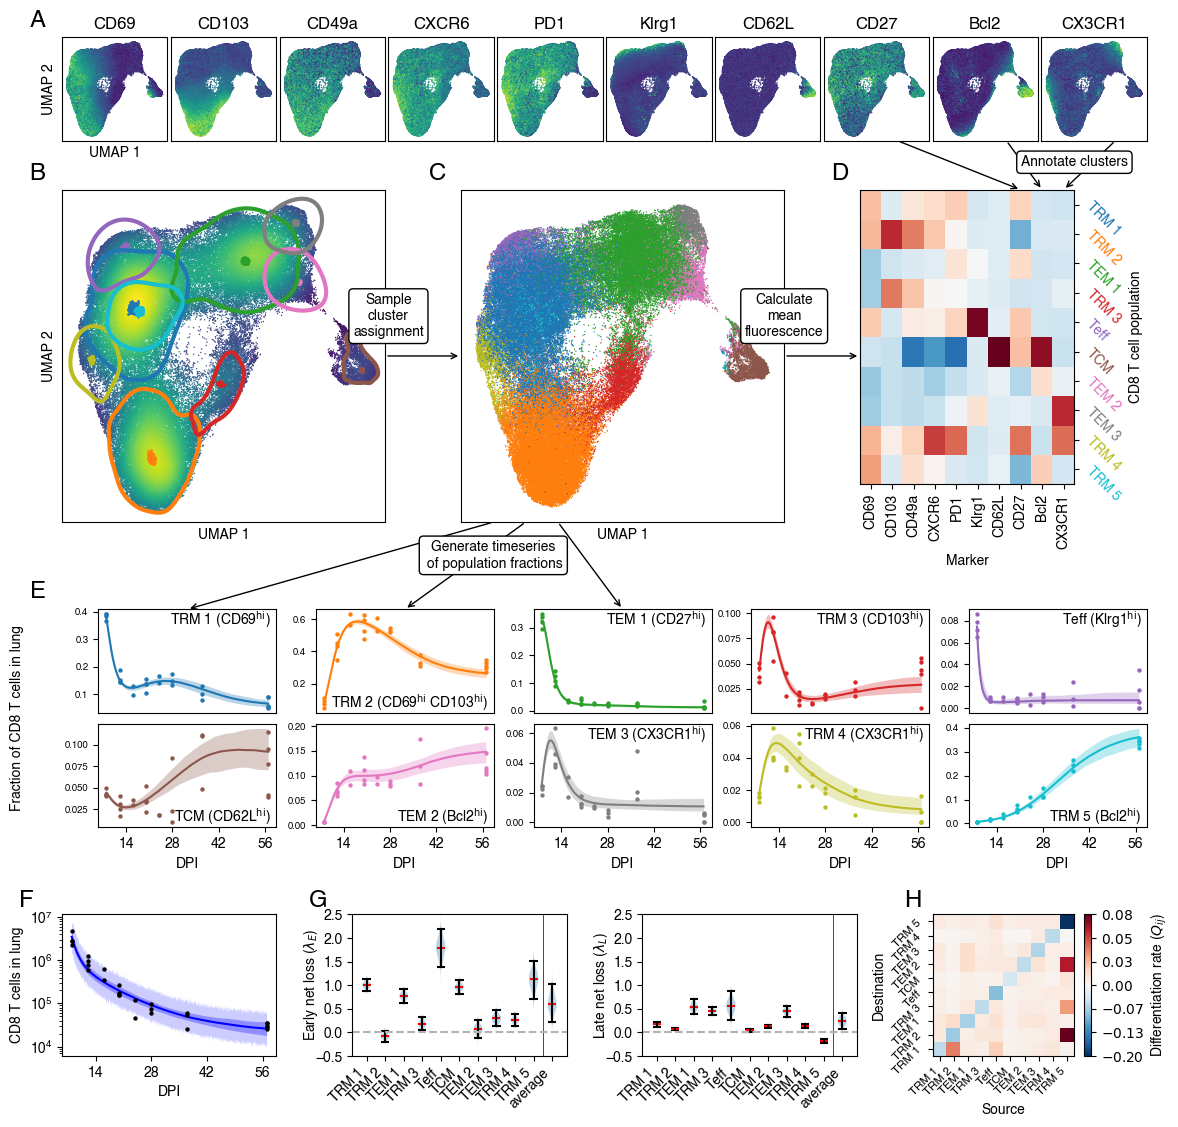

In [12]:
fig.align_ylabels([ax_heat, ax_counts, ax_freq])

fig

In [13]:
#fig.savefig("../results/FigureIntegratedFitCD8.pdf", bbox_inches='tight', dpi=200)